# IQC 2024/25 - Practical

## Setup

Install a clean Python environment and required modules: 

```bash
python -m venv .venv
.venv/bin/pip install pennylane matplotlib
```

Use `.venv/bin/python` as the Python kernel. 

Run imports below to test your environment. 

# IQC 2024/25 - Practical

## Setup

Install a clean Python environment and required modules: 

```bash
python -m venv .venv
.venv/bin/pip install pennylane matplotlib
```

Use `.venv/bin/python` as the Python kernel. 

Run imports below to test your environment. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pennylane as pl
from scipy.optimize import curve_fit



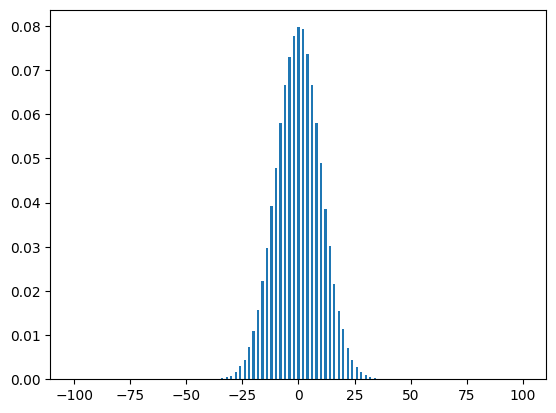

In [2]:
def random_walk(T, start = 0, p = .5):
  # Create a random sequence of 1 and -1 values. 
  steps = np.random.choice([1, -1], T, p = [p, 1 - p])
  return np.sum(steps)

N_STEPS = 100
N_SAMPLES = 100000
walks = [random_walk(N_STEPS) for _ in range(N_SAMPLES)]
plt.hist(walks, bins = 2 * N_STEPS + 1, density = True, range = (-N_STEPS - .5, N_STEPS + .5))
plt.show()

## Part 1 – Classical Random Walk

The random walk is a procedure, where at every time step an imaginary particle at given position has a random chance to move to next or previous position. The simplest example uses an unbiased coin to determine which direction to take. The goal of this exercise is for you to familiarise yourselves with the classical case before we move on to the quantum version. 

A very simple implementation of the random walk is given below. It simulates the position of the particle after *n* steps. Repeated calls can sample from different end positions. The probability $p$ can be modified for a biased coin. 

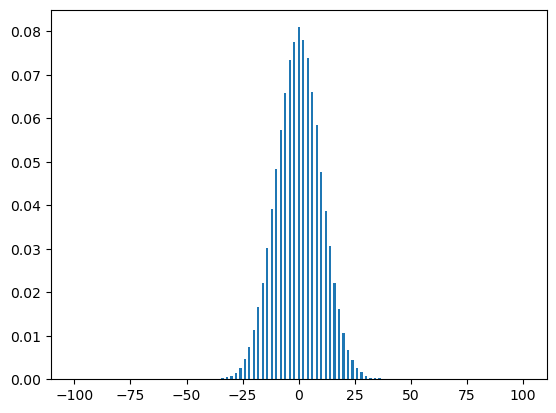

In [10]:
def random_walk(T, start = 0, p = .5):
  # Create a random sequence of 1 and -1 values. 
  steps = np.random.choice([1, -1], T, p = [p, 1 - p])
  return np.sum(steps)

N_STEPS = 100
N_SAMPLES = 100000
walks = [random_walk(N_STEPS) for _ in range(N_SAMPLES)]
plt.hist(walks, bins = 2 * N_STEPS + 1, density = True, range = (-N_STEPS - .5, N_STEPS + .5))
plt.show()

The walk above can reach any point in space. As in practice the size of the quantum register is finite, it is useful to add **boundary conditions** to the problem. In such a case, the particle is contained in a box of $n$ positions, from $0$ to $n - 1$, and start at position $\lfloor n / 2 \rfloor$. If the position exceeds the range of the box, the particle moves to the other side, i.e. from $0$ to $n - 1$, and from $n - 1$ to $0$. This can be visualised as if the particle was moving on a ring with first and last position connected. 

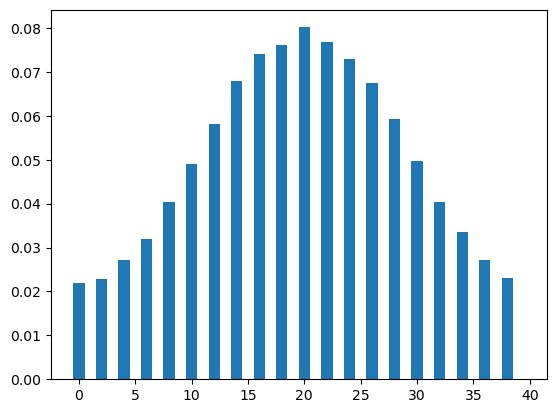

In [11]:
def random_walk_bc(n, max, start = None, p = .5):
  # By default start in the middle of the box. 
  if start is None: 
    start = max // 2
  
  # Create a random sequence of 1 and -1 values. 
  steps = np.random.choice([1, -1], n, p = [p, 1 - p])
  return (start + np.sum(steps)) % max

N_STEPS = 100
N_STATES = 40
N_SAMPLES = 100000
walks = [random_walk_bc(N_STEPS, N_STATES) for _ in range(N_SAMPLES)]
plt.hist(walks, bins = N_STATES, density = True, range = (-.5, N_STATES - .5))
plt.show()

The functions above simulate the random walk one by one. However, there exists a different approach, which allows calculating all probabilities at once. The idea is to represent the probabilities of ending up in a given position with an $n$ element vector, where the $k$-th element corresponds to the probability of finishing in position $k$. We initialise the starting state $\vec{p_0}$ with the basis vector corresponding to the starting position, such that the only non-zero element is at position $k$. E.g. for 4 elements, starting in position 2 looks as follows: 

$$
\vec{p}_0 = \vec{e}_2 = 
\begin{pmatrix}
  0 \\ 0 \\ 1 \\ 0
\end{pmatrix}$$

Now, we can represent the transitions at each time step with a matrix $M$. For any state $\vec{p}_k$, where $k$ corresponds to current position, there is a 50% chance to move to $k-1$ and 50% to move to $k+1$. Therefore, we need to create a matrix $M$ that implements this operation. To do this, we can decompose this matrix into a sum of permutations, such that $M = \frac{1}{2} P_+ + \frac{1}{2} P_-$, where $P_+$ corresponds to the upwards shift $\vec{e}_i \rightarrow \vec{e}_{(i + 1)\ \% \ n}$ and $P_-$ to the downwards shift $\vec{e}_i \rightarrow \vec{e}_{(i - 1)\ \% \ n}$. 

For example, for a box with 4 elements, the matrix is going to be the following: 

$$
M = \frac{1}{2} 
\begin{pmatrix}
  0 & 0 & 0 & 1 \\
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0
\end{pmatrix} 
+ \frac{1}{2} 
\begin{pmatrix}
  0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 1 \\
  1 & 0 & 0 & 0
\end{pmatrix}
= \frac{1}{2} 
\begin{pmatrix}
  0 & 1 & 0 & 1 \\
  1 & 0 & 1 & 0 \\
  0 & 1 & 0 & 1 \\
  1 & 0 & 1 & 0
\end{pmatrix}
$$

To calculate the final probabilities for starting state $\vec{v}_k$ and $T$ time steps, we can apply the following formula: 

$$\vec{p}_T = M^T \vec{p}_0$$

### Exercise 1 [10 marks]

Convince yourself why the formulation above works. Then, implement the following snippet of code. 
1. `transition_matrix(n, p)` implements the matrix $M$ for an arbitrary number of states $n$ and transition probability $p$ to the next state, and $1 - p$ to the previous state. *[2 marks]*
2. `random_walk_vec(n, T, start, p)` calculates the vector of probabilities $\vec{p}_T$, where $k$-th element in the vector gives the probability of ending up at the position $k$, given the starting state $\vec{p}_0$ with 1 at the starting position. *[4 marks]*
3. Finally, plot the results to check your implementation. For example, use the same parameters as in `random_walk_bc` above. Should the plots be exactly the same? Why or why not? Also, experiment with the number of time steps and qualitatively describe what happens as $T$ is increased. *[4 marks]*

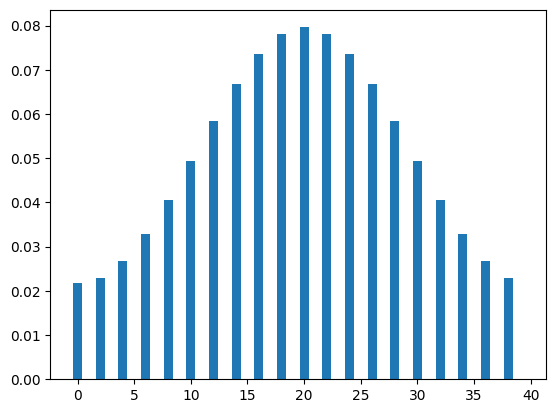

In [233]:
def transition_matrix(n, p = .5):
  # Start with identity
  id = np.identity(n, float)

  #make transition up
  up = np.concatenate([np.expand_dims(id[n-1], 0), id[:n-1]], axis=0)

  #make transition down
  down = np.concatenate([id[1:], np.expand_dims(id[0], 0)], axis=0)
  
  #weight by probabilities and add
  full = p * up + (1 - p) * down

  return full

def random_walk_vec(n, T, start = None, p = .5):
  if start is None:
    start = n // 2

  # initial state
  init = np.zeros(n, dtype = float)
  init[start] = 1.0

  #transition matrix
  trans = transition_matrix(n, p)

  #transition matrix to Tth power
  T_trans = np.linalg.matrix_power(trans, T)

  #apply T transitions to initial state
  result = init @ T_trans
  
  return result

n = 40
p = .5
T = 100
start = 20
probs = random_walk_vec(n, T, start = start, p = p)
plt.bar(range(n), probs)
plt.show()


>The probabilities should not be exactly the same with finite samples, but the samples above are drawn from the exact probabilities that are shown. Thus, in the limit as the samples go to infinity, the results will be exactly the same.

>As T increases, there is more time for the process to spread out. Thus, we see a flattening of the gaussian over time.


## Part 2 – Quantum Walk in 1D

Since we reformulated the random walk problem using linear algebra, it is interesting to see if there is an equivalent quantum circuit that could implement this. Unfortunately, the matrix $M$ is non-unitary, and we need to find a way to make it unitary, as these are the only valid evolutions in quantum computers. 

One of the approaches is to separate the actions of our imaginary particle moving up and down its current position. We could have a quantum register $\lvert \rho_0 \rangle$ of $N$ qubits representing $n = 2^N$ possible states, such that the probability of measuring a basis state $\lvert k \rangle$ corresponds to the probability of the particle ending up at position $k$. In other words, the element  $\lvert \langle k \vert \rho_T \rangle \rvert^2$ is equivalent to the $k$-th element of $\vec{p}_T$ defined in the previous section. 

Now, we can define unitary transition matrices for both next and previous state. Let 
$$\hat{U}_- \lvert k \rangle = \lvert (k - 1) \ \% \ n \rangle$$
$$\hat{U}_+ \lvert k \rangle = \lvert (k + 1) \ \% \ n \rangle$$
be those operators. You can prove that both are unitary. 

Let us think about how to implement the transition matrices. We can start with a simple example on 4 qubits, where $\lvert k \rangle \rightarrow \lvert k + 1 \rangle$. $\lvert k \rangle$ can be written down in the binary representation: 
$$\lvert k \rangle = \lvert \overline{k_3 k_2 k_1 k_0} \rangle = \lvert k_0 \rangle \lvert k_1 \rangle \lvert k_2 \rangle \lvert k_3 \rangle$$
If $k_0 = 0$, then it is increased to 1, and then the operation is finished. However, if $k_0 = 1$, then the addition is carried over to the next qubit. In both cases, $\lvert k_0' \rangle = \hat{X}\lvert k_0 \rangle$. However, in the second case, we also need to add 1 to $\lvert k_1 \rangle$, which means applying an $\hat{X}$ gate conditional on the first qubit being 0. This is then repeated recursively for the following qubits. 

*Note: all exercises below use little-endian ordering, where lower-index qubits represent smaller powers of two when reading the register.*

### Exercise 2 [15 marks]

Pennylane gives you access to controlled gates with an arbitrary number of control qubits, and either 0 or 1 as control values. Implement both $\hat{U}_+$ and $\hat{U}_-$ operators using controlled $\hat{X}$ gates. Then test and print your circuit. 

1. `mC0X(target)` should be a helper function that applies an $\hat{X}$ gate controlled by 0 values for all qubits below it (i.e. lower index). For example the gate created for `target = 2` may look as follows: *[3 marks]*
    ```
    # Q0: ────╭○──── #
    # Q1: ────├○──── #
    # Q2: ────╰X──── #
    # Q3: ────────── #
    # ...            #
    ```

2. `U_plus()` applies the next-state transition unitary to the entire register. You can use the helper gates here. *[2 marks]*
3. `U_minus()` applies the previous-state transition unitary to the entire register. You can use the helper gates here. Since the explanation above is only for the plus unitary, think about its relation to the minus unitary. Hint: consider unitarity. *[4 marks]*
4. Use Pennylane to draw both `U_plus` and `U_minus` circuits defined above. *[1 marks]*
5. `circuit()` represents a simple circuit to test the plus and minus gates. Feel free to do whatever you need here to verify that your gates are working correctly. How do you convert between Pennylane output and integer states? Are the boundary transitions between $\lvert 0 \rangle$ and $\lvert 2^N - 1 \rangle$ as expected? *[5 marks]*

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


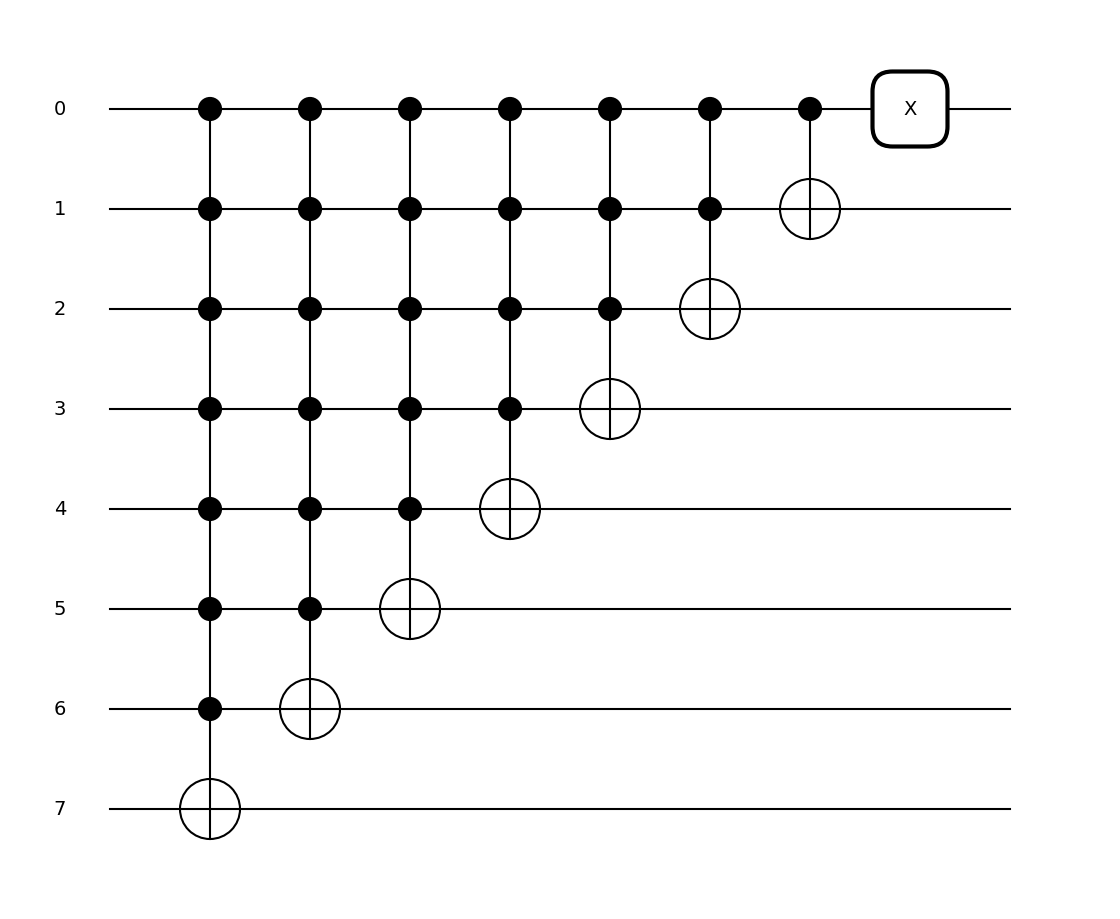

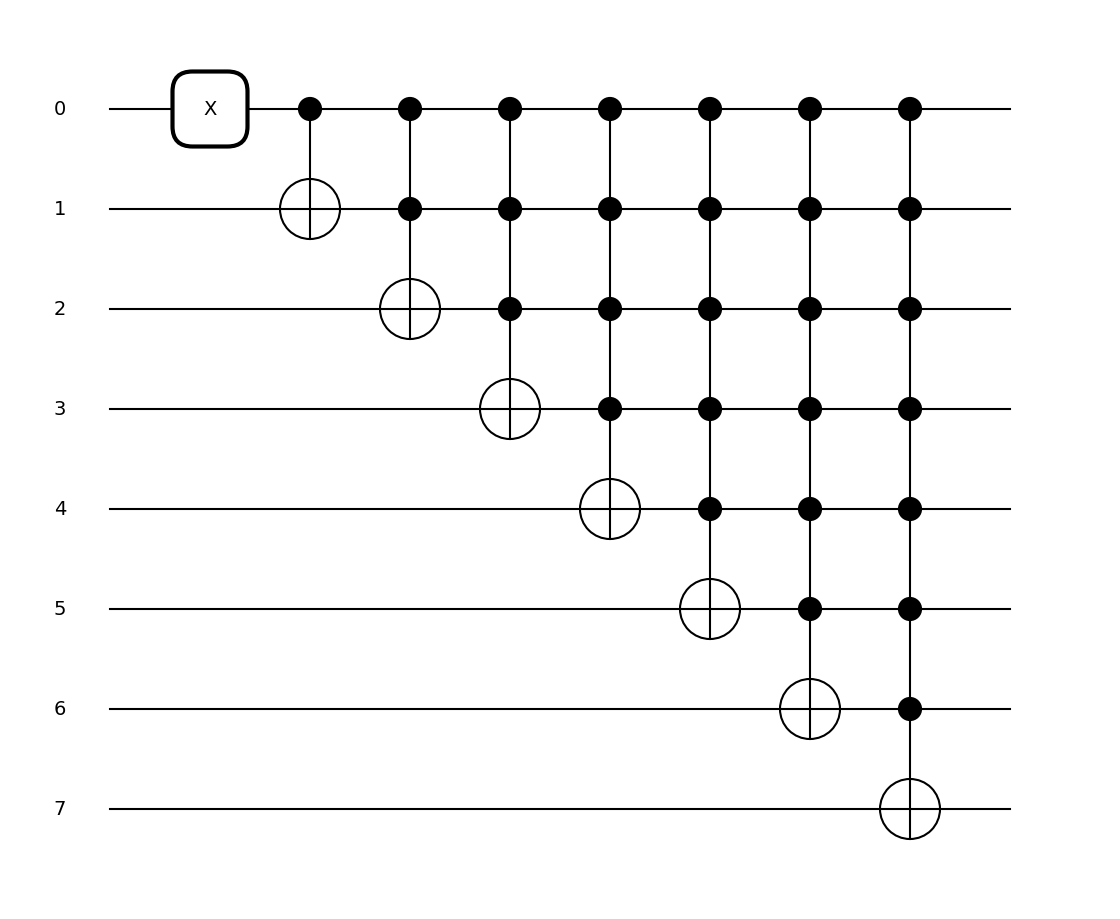

In [107]:
N_WIRES = 8
dev = pl.device("default.qubit", wires = N_WIRES, shots = 100)

# Multi-controlled X gate. 
def mC0X(target):
  pl.MultiControlledX(range(target + 1))

# +1 transition unitary. 
def U_plus():
  def Unitary():
    for i in reversed(range(N_WIRES)):
      if i != 0:
        mC0X(i)
    pl.X(0)
  return Unitary

# -1 transition unitary. 
def U_minus():
  #U_minus is the inverse of U_plus, we can apply all operations in reverse
  def Unitary():
    pl.X(0)
    for i in range(N_WIRES):
      if i != 0:
        mC0X(i)
  return Unitary
  

# Draw the circuits here. 
pl.draw_mpl(U_plus())()
pl.draw_mpl(U_minus())()

@pl.qnode(dev)
def circuit():
  # Test your methods here. 
  #should be identity
  U_plus()
  U_minus()

  #reverse wire order to convert big endian to little endian
  return pl.probs(wires=list(reversed(range(N_WIRES))))

# Convert and check your results below. 
res = circuit()
print(res)


> Pennylane outputs in big endian. To get the little endian result that we want I simply switched the order of the wires when computing the probabilities.

> The boundary transitions are as expected. I tested this by performing the minus operation on the zero state. The result was the maximum state.
> ...

We learnt how to move each the state either up or down, but how do we apply both according to given probabilities? The trick is to utilise an ancilla qubit to represent the superposition of $\lvert 0 \rangle$ and $\lvert 1 \rangle$ states. This qubit we can call the **coin qubit**, and it can be used as control to each of the operators above, so that both operations are applied at once, i.e. 
$$\hat{M} \lvert 0 \rangle \lvert k \rangle = \lvert 0 \rangle \lvert (k - 1) \ \% \ n \rangle$$
$$\hat{M} \lvert 1 \rangle \lvert k \rangle = \lvert 1 \rangle \lvert (k + 1) \ \% \ n \rangle$$

A **quantum walk** step then looks as follows: 

![image](walk-step.svg)

This is then repeated $T$ times for $T$ time steps. Importantly, the Hadamard gate is applied for every step. For now, the coin register is initialised to $\lvert 0 \rangle$. 

### Exercise 3 [15 marks]
Reimplement the -1 and +1 operators from exercise 2 conditional on the coin qubit. Use them to write a full quantum walk. Feel free to add helper functions similar to `mC0X` above. 

1. Write `CU_plus()` and `CU_minus()`, which are now controlled by the coin qubit. Be careful which control values to use. *[4 marks]*
2. Write `quantum_walk(T)`, which is a quantum walk with $T$ steps. The walk should start *in the middle state* (i.e. $\frac{1}{2} \cdot 2^N$). *[4 marks]*
3. Plot the histogram of your results, similar to the ones in part 1. Explain what is different about the classical and quantum case. Why do you think this is the case? What happens if you vary the number of time steps $T$? *[7 marks]*

<BarContainer object of 128 artists>

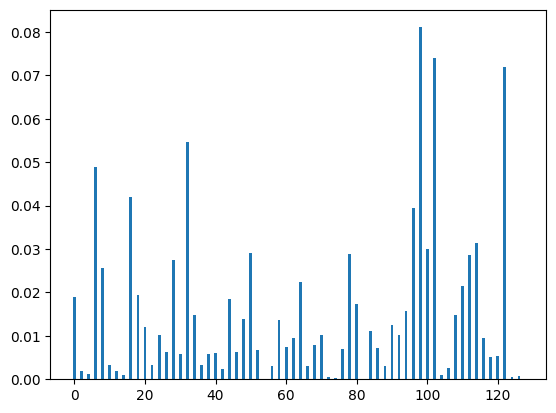

In [239]:
N_WIRES = 7
dev = pl.device("default.qubit", wires = ["coin", *range(N_WIRES)], shots = 10000)

# Controlled +1 transition unitary. 
def CU_plus():
  pl.ctrl(U_plus(), control=["coin"], control_values=[1])()

# Controlled -1 transition unitary. 
def CU_minus():
  pl.ctrl(U_minus(), control=["coin"], control_values=[0])()

# Quantum walk with T steps. 
@pl.qnode(dev)
def quantum_walk(T):
  #find middle and encode initial state
  middle = 2 ** (N_WIRES - 1)
  for i in range(middle.bit_length()):
    bit = (middle >> i) & 1
    if bit == 1:
      pl.X(i)
  
  #perform T iterations
  for i in range(T):
    pl.Hadamard(wires="coin")
    CU_plus()
    CU_minus()
  return pl.probs(wires=np.arange(N_WIRES - 1, -1, -1))

# Plot the results below. 
res = quantum_walk(500)
plt.bar(range(len(res)), res)

> The results differ greatly between the classical and quantum monte carlo. This is because of the interference of waves. We can see local highs and lows in the probabilities for the quantum monte carlo, whereas the classical monte carlo is smooth. This is a result of constructive and destructive interference patterns.

> Similar to the classical monte carlo, as time progresses the process spreads out. This flattens the distribution with time. Although, in the classical case, after long times the distribution becomes uniform. In the quantum case, it is unclear emperically if interference patterns prevent this.
> ...

### Exercise 4 [10 marks]
Test what happens if the coin qubit is initialised to a different state than $\lvert 0 \rangle$. 

1. Write a function `init_coin(theta, phi)`, which rotates the coin qubit to an arbitrary state of the following form: *[3 marks]*

$$\lvert \psi_{coin} \rangle = \cos{(\theta)} \lvert 0 \rangle + {\rm e}^{i\phi} \sin{(\theta)} \lvert 1 \rangle$$

2. Rewrite `quantum_walk(T, theta, phi)`, with two new parameters that can be passed to `init_coin`. What do your results look like if you initialise the coin in state $\lvert \psi_{coin} \rangle = \lvert 1 \rangle$? What about $\lvert \psi_{coin} \rangle = \frac{1}{\sqrt{2}} (\lvert 0 \rangle + i \lvert 1 \rangle)$? Plot your results for both cases. How would you choose the number of time steps $T$? *[7 marks]*

<BarContainer object of 128 artists>

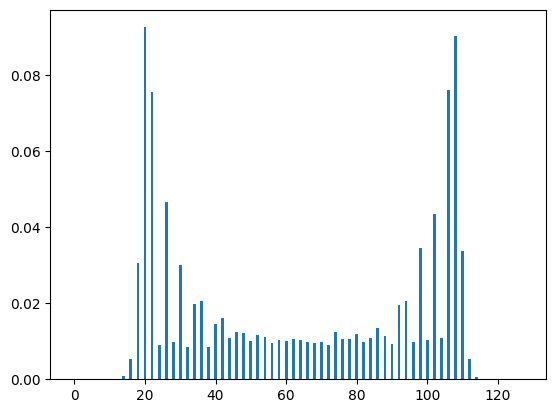

In [151]:
# Init general coin register. 
def init_coin(theta, phi):
  def rotation():
    pl.RX(2 * theta, wires="coin")
    pl.RY(phi, wires="coin") 
  return rotation

# Quantum walk with T steps, and given coin parameters. 
@pl.qnode(dev)
def quantum_walk(T, theta = 0, phi = 0):
  #perform rotation
  

  #find middle and encode initial state
  middle = 2 ** (N_WIRES - 1)
  for i in range(middle.bit_length()):
    bit = (middle >> i) & 1
    if bit == 1:
      pl.X(i)
  
  
  init_coin(theta, phi)()
  #perform T iterations
  for i in range(T):
    pl.Hadamard(wires="coin")
    CU_plus()
    CU_minus()
  return pl.probs(wires=np.arange(N_WIRES - 1, -1, -1))
  
# Plot the results below. 
res = quantum_walk(64, np.pi/4, np.pi/2)
plt.bar(range(len(res)), res)

> When the initial state is set to |1> instead of |0>. The resulting probabilities are mirrored. When the initial state is set to 1/sqrt(2)[|0> + i|1>], the probabilities become symmetric across the middle (at least roughly, there is some difference in the plot, but I'm attributing it to numerical instability).

> I would choose a number of time steps large enough that the probability ditribution sufficiently spreads out, but small enough that it has not reflected over the boundary yet. This way I can compare the results of different initial states.
> ...

Given a symmetric random walk, the expected value of position is naturally always going to be 0. Thus, to quantify how different walks spread, we can calulate the standard deviation of position,

$$\sigma(t)=\sqrt{\sum_{n=-\infty}^{\infty} x^2 p(T, n)}.$$

Where here $x$ is the displacement relative to initital position, and $p(t, x)$ is the probability distribution of a walk after a number of timesteps, T. Given a walk in an *infinite space*, one can use the standard deviation to quantify how far a random walk spreads.

### Exercise 5 [10 marks]

1. Implement `standard_deviation()`, a function which calculates the standard deviation of position from samples of a walk (in 1d). *[2 marks]*
2. Plot the standard deviation against timesteps for both the quantum and the classical 1d walks. Be careful to consider the effects of a boundary conditions, as we currently only have quantum walks on a *finite* space. *[4 marks]*
3. Fit the results with the given fitting function. Describe how the spread of classical and quantum walks differ, and why this may be relevant to quantum computing.  *[4 marks]*

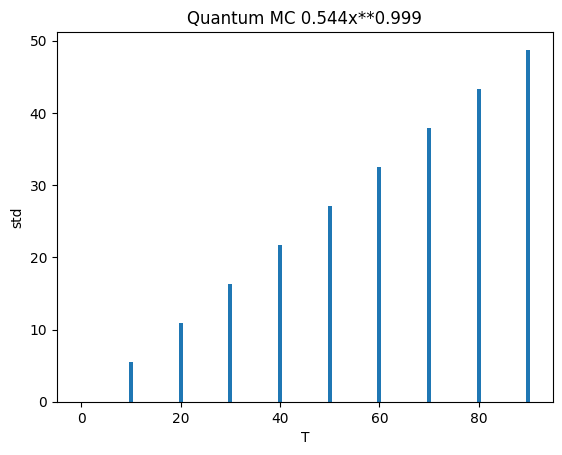

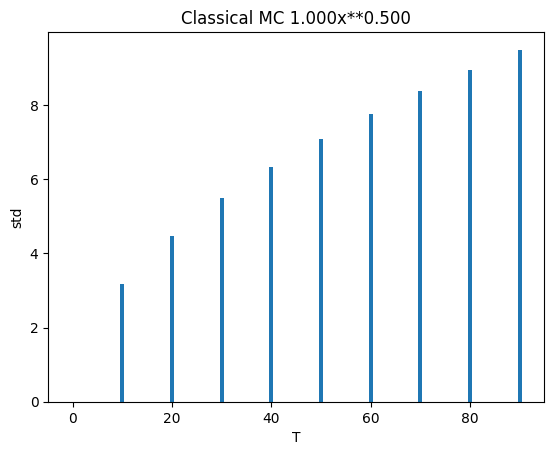

In [162]:
# You may use previously defined random_walk_vec and quantum_walk functions.

# Feel free to add more arguments in the function below. 
def standard_deviation(probs, start_idx):
  result = 0
  for i, prob in enumerate(probs):
    result += np.square(i - start_idx) * prob
  result = np.sqrt(result)
  return result



# Fitting function
# You should use curve_fit which is already imported from scipy.optimize
def power_law(t, a, b):
  return a * t**b


# Plot the results below.\
Ts = np.arange(0, 100, 10)
n = 2 ** N_WIRES
start = 2 ** (N_WIRES - 1)
quantum_std = []
classical_std = []
for T in Ts:
  #always use symmetric coin for fair comparison
  probs = quantum_walk(T, np.pi/4, np.pi/2)
  quantum_std.append(standard_deviation(probs, start))

  probs = random_walk_vec(n, T, start=start, p = .5)
  classical_std.append(standard_deviation(probs, start))

params, _ = curve_fit(power_law, Ts, quantum_std)
a, b = params
plt.bar(Ts, quantum_std)
plt.title(f"Quantum MC {a:.3f}x**{b:.3f}")
plt.xlabel("T")
plt.ylabel("std")
plt.show()

params, _ = curve_fit(power_law, Ts, classical_std)
a, b = params
plt.bar(Ts, classical_std)
plt.title(f"Classical MC {a:.3f}x**{b:.3f}")
plt.xlabel("T")
plt.ylabel("std")
plt.show()


> The standard deviation of quantum monte carlos grow linearly with time, whereas the standard deviation of classical monte carlos grow by the square root with time. 

> Since quantum systems have such high variance. They are difficult to simulate on classical computers. Quantum computers (should) allow these systems to be simulated precisely.
> ...

## Part 3 – 2D Quantum Walk

Now you can use all of the ideas from previous part to construct a similar circuit that conducts the quantum walk in 2-dimensions. 


![image](2d-grid.svg)

You can assume that the grid is of dimensions $2^N \times 2^M$, so the first $M$ qubits represent columns, while the next $N$ represent rows. Use named registers to help you identify which qubits you are acting on. Instead of -1 and +1 transitions, now you will need left, right, up and down transitions. To control them, use two coin qubits, one for vertical directions, and one for horizontal. 

### Exercise 6 [25 marks]

Use the ideas from previous exercises to implement a 2D quantum walk below. Make it flexible for different numbers of column and row qubits. This time, return the expectation value instead of samples. Feel free to define any helper methods. 

1. Implement gates for transitions in each Cartesian direction. Make horizontal transitions controlled on one qubit, and horizontal transitions controlled on the other qubit. Make use of named wires. *[12 marks]*
2. Implement the 2D quantum walk. Make it return the expectation value instead of a sample. For now, leave the initial coin state as $\lvert 00 \rangle$. *[4 marks]*
3. Test your code and plot the results (e.g. as 2D histograms) for different $T$ on a 16x32 grid. How do they compare to the 1D case? How would you expect them to change for different initial states? *[9 marks]*

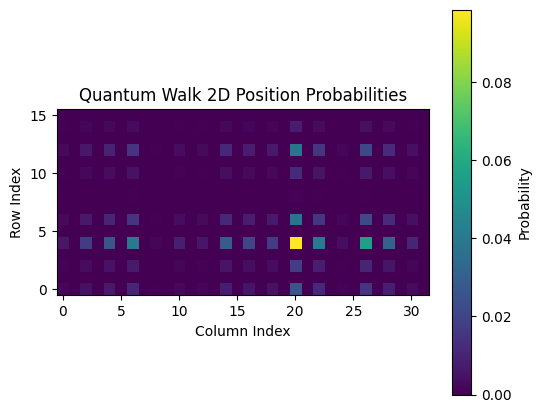

In [241]:
COIN_REG = ("coin1", "coin2")
COL_REG = ("col0", "col1", "col2", "col3", "col4")
ROW_REG = ("row0", "row1", "row2", "row3")
dev = pl.device("default.qubit", wires = COIN_REG + COL_REG + ROW_REG)

# Multi-controlled X gate. 
def mC0Xrow(target):
  '''
  Args:
    - target: the row number
  '''
  if target == 0:
    pl.X(ROW_REG[0])
  else:
    pl.MultiControlledX(ROW_REG[:target + 1])

def mC0Xcol(target):
  '''
  Args:
    - target: the col number
  '''
  if target == 0:
    pl.X(COL_REG[0])
  else:
    pl.MultiControlledX(COL_REG[:target + 1])

# Previous column transition unitary
def CCU_left():
  def Unitary():
    for i in range(len(COL_REG)):
      mC0Xcol(i)
  pl.ctrl(Unitary, control=["coin2"], control_values=[0])()

# Next column transition unitary
def CCU_right():
  def Unitary():
    for i in reversed(range(len(COL_REG))):
      mC0Xcol(i)
  pl.ctrl(Unitary, control=["coin2"], control_values=[1])()

# Previous row transition unitary
def CCU_up():
  def Unitary():
    for i in reversed(range(len(ROW_REG))):
      mC0Xrow(i)
  pl.ctrl(Unitary, control=["coin1"], control_values=[1])()

# Next row transition unitary
def CCU_down():
  def Unitary():
    for i in range(len(ROW_REG)):
      mC0Xrow(i)
  pl.ctrl(Unitary, control=["coin1"], control_values=[0])()

@pl.qnode(dev)
def quantum_walk_2d(T):
  for _ in range(T):
    pl.H("coin1")
    pl.H("coin2")
    CCU_left()
    CCU_right()
    CCU_down()
    CCU_up()
  return pl.probs(wires= COL_REG[::-1] + ROW_REG[::-1])


# Plot the results below. 
probs = quantum_walk_2d(64)
probs = probs.reshape((2**len(COL_REG), 2**len(ROW_REG))).T

plt.figure(figsize=(6, 5))
plt.imshow(probs, cmap="viridis", origin="lower")
plt.title("Quantum Walk 2D Position Probabilities")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.colorbar(label="Probability")
plt.show()

> Similar to the 1D case. There are few states with high probabilities, and many states with near 0 probability. Additionally, the 2D quantum monte carlo is also not smooth, which differs from the classical case. Lastly, over time the monte carlo spreads out from a point, similar to the 1D case.

> For different initial states. I would expect the point from which the monte carlo spreads out to change. 
> ...

The double Hadamard gate applied to the coin register before each walk step is called the **Hadamard coin**. This is not the only coin valid for the quantum walk. Let's consider the following two additional coins:
* The **Fourier coin**: 

$$
\hat{F}_4 = \frac{1}{2} \begin{pmatrix}
1 &  1 &  1 &  1 \\
1 &  i & -1 & -i \\
1 & -1 &  1 & -1 \\
1 & -i & -1 &  i
\end{pmatrix}
$$

* The **Grover coin**: 

$$
\hat{G}_4 = \frac{1}{2} \begin{pmatrix}
-1 &  1 &  1 &  1 \\
 1 & -1 &  1 &  1 \\
 1 &  1 & -1 &  1 \\
 1 &  1 &  1 & -1
\end{pmatrix}
$$


### Exercise 7 [15 marks]

Modify your code for the 2D quantum walk to allow arbitrary initial state and coin gate. Plot the results for the following configurations: 
1. Hadamard coin and $\frac{1}{2} (\lvert 0 \rangle + i \lvert 1 \rangle) \otimes (\lvert 0 \rangle + i \lvert 1 \rangle)$ initial state. *[4 marks]*
2. Fourier coin and $\frac{1}{2} (\lvert 00 \rangle + e^{-\pi/4} \lvert 01 \rangle + \lvert 10 \rangle - e^{-\pi/4} \lvert 11 \rangle)$ initial state. *[4 marks]*
3. Grover coin and $\lvert - \rangle \otimes \lvert - \rangle$ initial state. *[4 marks]*
4. Describe how the results differ from each other. Suggest why this is the case. *[3 marks]*

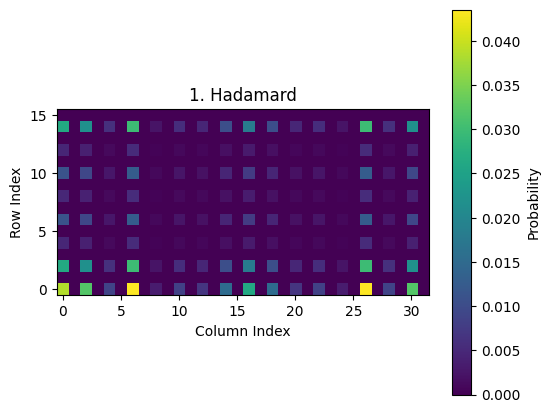

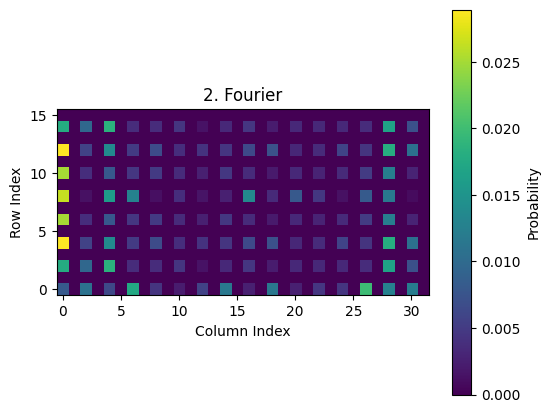

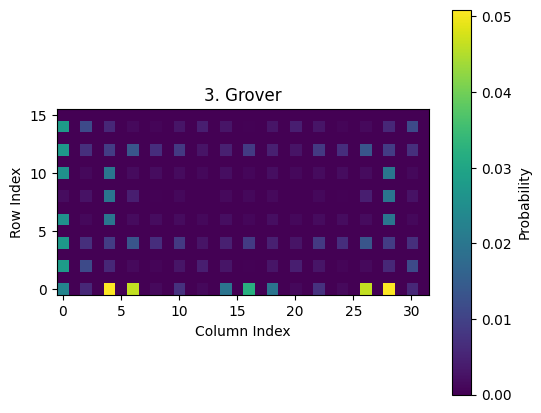

In [242]:
# Feel free to add more arguments in the function below.

@pl.qnode(dev)
def quantum_walk_2d(T, coin="hadamard", psi00=1, psi01=0, psi10=0, psi11=0):
  coin_state = np.array([psi00, psi01, psi10, psi11])
  pl.StatePrep(coin_state, wires=["coin1", "coin2"])
  for _ in range(T):
    if coin == "hadamard":
      pl.H("coin1")
      pl.H("coin2")
    if coin == "fourier":
      fourier = 0.5 * np.array([
        [1, 1, 1, 1],
        [1, 1j, -1, -1j],
        [1, -1, 1, -1],
        [1, -1j, -1, 1j]
      ])
      pl.QubitUnitary(fourier, wires=["coin1", "coin2"])
    if coin == "grover":
      grover = 0.5 * np.array([
        [-1, 1, 1, 1],
        [1, -1, 1, 1],
        [1, 1, -1, 1],
        [1, 1, 1, -1]
      ])
      pl.QubitUnitary(grover, wires=["coin1", "coin2"])

    CCU_left()
    CCU_right()
    CCU_down()
    CCU_up()
  return pl.probs(wires= COL_REG[::-1] + ROW_REG[::-1])


# Plot the results below. 
def plot(T, coin_type, psi00, psi01, psi10, psi11, plot_title="Quantum Walk 2D Position Probabilities"):
  probs = quantum_walk_2d(T, coin=coin_type, psi00=psi00, psi01=psi01, psi10=psi10, psi11=psi11)
  probs = probs.reshape((2**len(COL_REG), 2**len(ROW_REG))).T

  plt.figure(figsize=(6, 5))
  plt.imshow(probs, cmap="viridis", origin="lower")
  plt.title(plot_title)
  plt.xlabel("Column Index")
  plt.ylabel("Row Index")
  plt.colorbar(label="Probability")
  plt.show()

plot(100, "hadamard", 0.5, 0.5j, 0.5j, -0.5, "1. Hadamard")
plot(100, "fourier", 0.5, np.exp(-np.pi/4), 0.5, -np.exp(-np.pi/4), "2. Fourier")
plot(100, "grover", 0.5, -0.5, -0.5, 0.5, "3. Grover")

> The hadamard pattern has some sections with 0 probability. I suppose this is the case because there is no complex number in the haamard transform, which allows probabilities to cancel more easily. 

> The fourier pattern is pretty sporatic which I attribute to the high variety of positive/negative and real/imaginary values in the matrix. This makes perfect cancelation of probabilities hard.

> The grover pattern has one massive gap in probability at the center. I attribute this to the -1 values along the diagonal.